# Solving blackjack using Monte Carlo Policy Optimization

In [1]:
""" Imports """

import numpy as np
import random as rnd
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Entitie classes for the Dealer and Player, from a Person base-class

In [2]:
class Person:
    """ Base class for both Dealer and Player 
        Keeps track of cards, usable aces and score 
    """
    def __init__(self):
        self.cards = []
        self.wins = 0
        
    @property
    def usable_ace(self) -> bool:
        """ Checks if there is an ace and if it's usable (sum less than 22) """
        return 1 in self.cards and sum(self.cards) +10 <= 21
    
    @property
    def score(self) -> int:
        """ Adds 10 to the sum of cards if there is a usable ace """
        _sum = sum(self.cards)
        return _sum +10 if self.usable_ace else _sum

    
class Dealer(Person):
    """ Dealer follows simple policy and has a card shown """
    def __init__(self):
        super(Dealer, self).__init__()
        
    def policy(self, offset=0) -> int:
        """ Stick if score is 17 or higher """
        return 0 if self.score >= 17 +offset else 1
    
    @property
    def shown(self) -> int:
        """ Card that the Player can see (first in list) """
        return self.cards[0] if len(self.cards) != 0 else None

    
class Player(Person):
    """ Player tracks state-action values and follows an epsilon greedy policy """
    def __init__(self, action_space={0: "stick", 1: "hit"}):
        self.action_space = action_space
        super(Player, self).__init__()
        
        dealer_shown, player_score = list(range(1,11)), list(range(4,22))
        self.state_action_value = np.zeros((
            2,                        # no-ace | usable ace
            len(self.action_space),   # each possible action
            len(dealer_shown),        # possible dealer card
            len(player_score),        # possible start pair
        ))
        
    def policy(self, state: tuple, eps=0.01, tie_breaker=True) -> int:
        """ Epsilon greedy policy """
        if 1-eps < rnd.random(): return rnd.choice(list(self.action_space))
        
        idx = self.state_to_idx(state)
        if tie_breaker and np.equal(*self.state_action_value[idx[0], ..., idx[1], idx[2]]):
            return 1
        return np.argmax(self.state_action_value[idx[0]], 0)[idx[1], idx[2]]
    
    @classmethod
    def state_to_idx(cls, s:tuple) -> tuple:
        """ Offsets the state to match the array indexing """
        return int(s[0]), s[1]-1, s[2]-4
    
    @classmethod
    def state_action_to_idx(cls, s:tuple, a:int) -> tuple:
        """ Offsets the state-action to match the array indexing """
        return int(s[0]), a, s[1]-1, s[2]-4

# Environment class for simulating Blackjack games

In [3]:
class Table:
    def __init__(self):
        """ Represents a blackjack table with a dealer and player
            In charge of dealing cards, initializing games and resetting table
            Passes states to the player and executes it's and dealer's actions 
        """
        self.player = Player()
        self.dealer = Dealer()
        self.deck = list(range(1, 11)) + [10,10,10]
        
    def deal(self, target: Person, count=1) -> None:
        """ Gives the passed person x-amount of cards """
        for _ in range(count):
            target.cards.append(rnd.choice(self.deck))
            
    def initialize(self) -> None:
        """ Gives both dealer and player 2 cards """
        self.deal(self.dealer, 2)
        self.deal(self.player, 2)
        
    def reset(self) -> None:
        """ Resets game variables for dealer and player """
        for p in [self.dealer, self.player]:
            p.cards = []
            p.sum = 0
    
    @classmethod
    def states_iter(self) -> tuple:
        """ Generator yielding every possible state-idx """
        for y in range(10):
            for x in range(18):
                yield(y, x)
    
    @property
    def state(self) -> tuple:
        """ State: usable ace, dealer card & player's card score """
        return self.player.usable_ace, self.dealer.shown, self.player.score
            
    def blackjack(self, eps=0.5) -> tuple:
        """ Game loop for a single simulated blackjack game
            Player actions are chosen following eps-greedy policy
            Returns game outcome, states visited & actions taken 
        """
        self.reset() # Reset table
        self.initialize() # Deal cards
        
        states, actions = [self.state], []
        
        # Natural WIN +1
        if self.player.score == 21 and self.dealer.score != 21:
            self.player.wins += 1
            return 1, states, actions
        
        # Player actions
        while self.player.policy(states[-1], eps):
            actions.append(1)
            
            self.deal(self.player)
            states.append(self.state)
            if self.player.score > 21:
                return -1, states, actions     # Player BUST -1
            
        else:
            actions.append(0)
            
            # Dealer finishes the game
            while self.dealer.policy():
                self.deal(self.dealer)
                if self.dealer.score > 21:
                    return 1, states, actions  # Dealer BUST +1 
            
            # Outcome of the game
            if self.dealer.score == self.player.score:
                return 0, states, actions      # Game DRAW +0
            elif self.dealer.score < self.player.score:
                self.player.wins += 1
                return 1, states, actions      # Player WIN +1
            else: 
                self.dealer.wins += 1
                return -1, states, actions     # Dealer WIN -1

# Quick check to see if everything still functions as should

In [5]:
def sanity_check(game):
    print("Player cards:", game.player.cards)
    print("Player score:", game.player.score)
    print("Dealer's shown card:", game.dealer.shown)

game = Table()
game.initialize()
sanity_check(game)
print("\nDealer score:", game.dealer.score)
print("Dealer action:", game.dealer.policy(), "\n")
game.reset()
sanity_check(game)

print("\nSimulated game returns:")
reward, states, actions = game.blackjack()
print("States:", *states)
print("Actions:", *actions)
print("Reward:", reward)
print("Cards:", game.player.cards)
print("Idx:", Player.state_action_to_idx(states[0], actions[0]))

print("\nQ(s,a) shape:", game.player.state_action_value.shape)

Player cards: [9, 6]
Player score: 15
Dealer's shown card: 2

Dealer score: 11
Dealer action: 1 

Player cards: []
Player score: 0
Dealer's shown card: None

Simulated game returns:
States: (True, 3, 18)
Actions: 0
Reward: -1
Cards: [1, 7]
Idx: (1, 0, 2, 14)

Q(s,a) shape: (2, 2, 10, 18)


# Blackjack pair probabilities

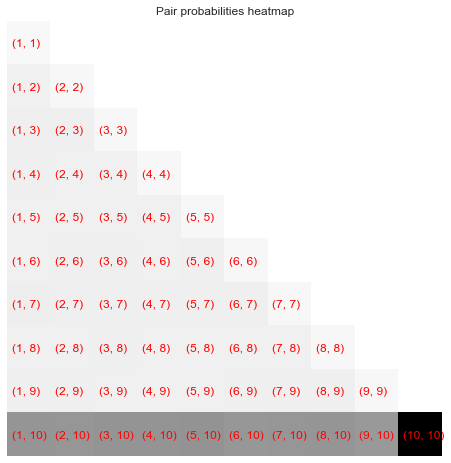

In [99]:
pairs = {
    tuple(sorted([y,x])): 0 
    for y in range(1, 11) 
     for x in range(1, 11)
}

game = Table()
for _ in range(int(1e5)):
    game.reset()
    game.initialize()
    pairs[tuple(sorted(game.player.cards))] += 1
    
plt.figure(figsize=(8, 8)); plt.gca().set_axis_off()
plt.title("Pair probabilities heatmap")
heatmap = np.zeros((10,10))
for (y,x), val in pairs.items():
    plt.text(y-1.4, x-0.9, (y,x), fontdict={"color": "r", "size":12})
    heatmap[y-1,x-1] = val
plt.imshow(heatmap.T);

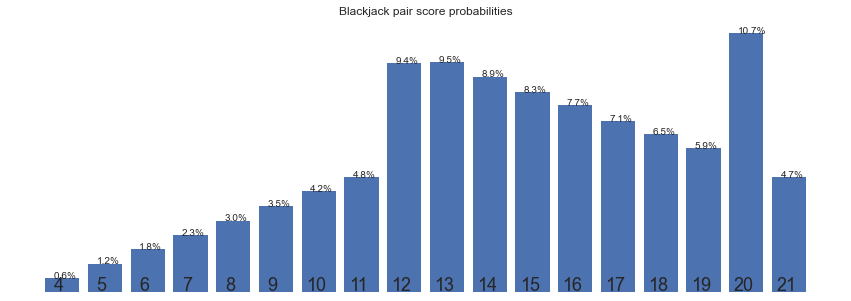

In [100]:
useable_ace = lambda pair: 1 in pair and 21 >= sum(pair) +10
hand_score = {k: 0 for k in set([sum(pair)+10 if useable_ace(pair) else sum(pair) for pair in pairs])}

game = Table()
for _ in range(int(1e6)):
    game.reset()
    game.initialize()
    score = sum(game.player.cards)
    hand_score[score+10 if useable_ace(game.player.cards) else score] += 1

plt.figure(figsize=(15, 5)); plt.gca().set_axis_off()
plt.title("Blackjack pair score probabilities")
plt.bar(list(range(len(hand_score))), list(hand_score.values()))
for score, count in hand_score.items():
    plt.text(score -4.2, count, f"{round(count /int(1e6) *100, 1)}%")
    plt.text(score -4.2 if len(str(score))==1 else score -4.3 , 1000, score, fontdict={"size": 18})

# Unintelligent game following dealer policy: Stick if sum >= 17

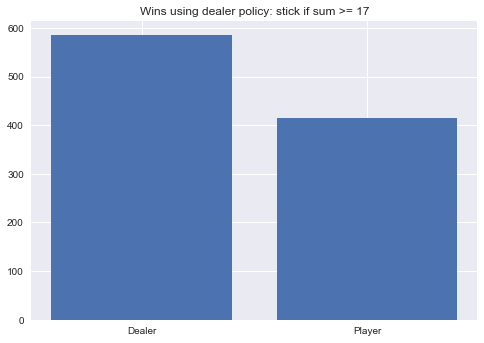

In [122]:
score = {"Dealer": [], "Player": []}

for i in range(100):
    game = Table()
    for i in range(1000):
        game.reset()
        game.initialize()
        if game.player.score == 21 and game.dealer.score != 21: 
            game.player.wins += 1         # NATURAL WIN 
            continue

        while game.player.score < 17:     # PLAYER HIT
            game.deal(game.player)
            if game.player.score > 21:
                game.dealer.wins += 1
                break
        else:                             # PLAYER STICK
            while game.dealer.policy():   # DEALER HIT
                game.deal(game.dealer)
            if game.dealer.score > 21 or game.dealer.score < game.player.score:
                game.player.wins += 1     # PLAYER WIN
            else: game.dealer.wins += 1   # DEALER WIN
                
    score["Dealer"].append(game.dealer.wins)
    score["Player"].append(game.player.wins)
    
plt.bar(["Dealer", "Player"], list(map(lambda m: sum(m)/len(m), score.values())))
plt.title("Wins using dealer policy: stick if sum >= 17"); plt.show()

# Blackjack simulation, environment feedback test

In [8]:
outcome = {-1: "Lost", 0: "Draw", 1:"Won"}

num_games = 3
game = Table()

for i in range(1, num_games +1):
    reward, states, actions = game.blackjack()
    print("Game", i, outcome[reward])
    print("States:", *states)
    print("Actions:", *actions)
    print()

Game 1 Lost
States: (False, 5, 20) (False, 5, 25)
Actions: 1

Game 2 Lost
States: (False, 7, 19) (False, 7, 24)
Actions: 1

Game 3 Lost
States: (False, 9, 8)
Actions: 0



# Monte Carlo ES (Exploring Starts), for estimating $\pi\approx\pi_*$

Simulation runs 10 million games, updating the players state-action values after each episode (game)

In [9]:
game = Table()

returns = np.zeros_like(game.player.state_action_value, dtype=float)
counts = np.zeros_like(game.player.state_action_value, dtype=int)
    
gamma = 1
num_games = int(1e7)
for i in range(1, num_games+1):
    reward, states, actions = game.blackjack(eps=0.5)
    
    expected = 0
    for step in reversed(range(len(actions))):
        idx = Player.state_action_to_idx(states[step], actions[step])
        counts[idx] += 1
        
        if step == len(actions)-1:
            expected = gamma *expected +reward
        else: expected = gamma *expected
            
        returns[idx] += (expected -returns[idx]) /counts[idx]
        game.player.state_action_value[idx] = returns[idx]
        
    if i % (num_games//10) == 0:
        print(f"State-action value optimization is {i//(num_games//100)}% done.")

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


# Evaluate state-action values and policy

In [4]:
def detailed_quality_plot(arr: np.ndarray, title="", figsize=(15,5)) -> None:
    """ Plots the passed array as heatmap with values shown """
    plt.figure(figsize=figsize)
    plt.imshow(arr)
    
    for (y,x), v in np.ndenumerate(arr):
        plt.text(x-.4, y, round(v, 2), fontdict={"color": "r", "size": 12})
        
    plt.title(title)
    plt.xlabel("Player card sum")
    plt.ylabel("Dealer shown card")
    
    ax = plt.gca()
    ax.set_xticks(range(18))
    ax.set_yticks(range(10))
    ax.set_xticklabels(list(range(4,22)))
    ax.set_yticklabels(["A"]+list(range(2,11)))
    
    plt.grid(False); plt.show()

### A. No usable ace policy

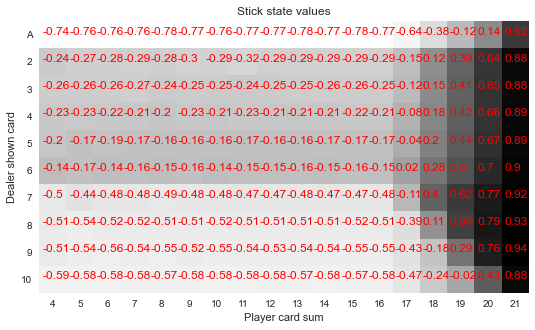

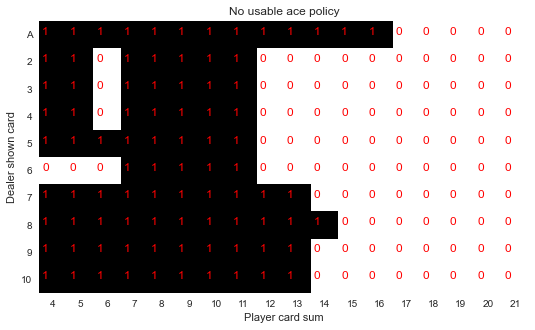

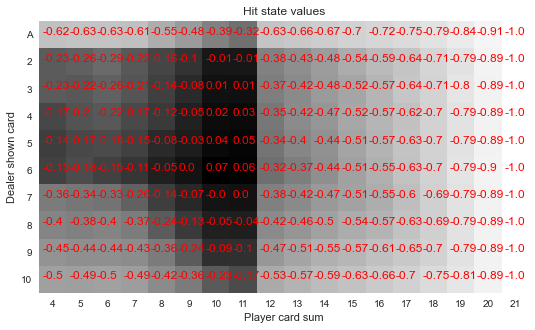

In [16]:
detailed_quality_plot(game.player.state_action_value[0, 0], "Stick state values")
detailed_quality_plot(np.argmax(game.player.state_action_value[0], 0), "No usable ace policy")
detailed_quality_plot(game.player.state_action_value[0, 1], "Hit state values")

### B. Usable ace policy

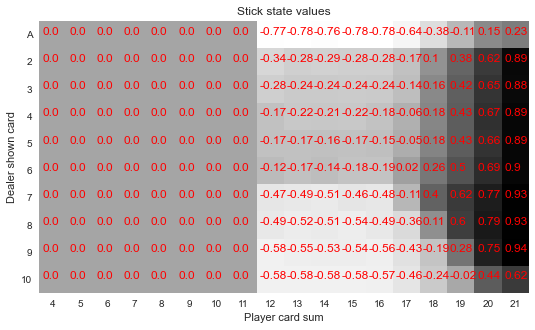

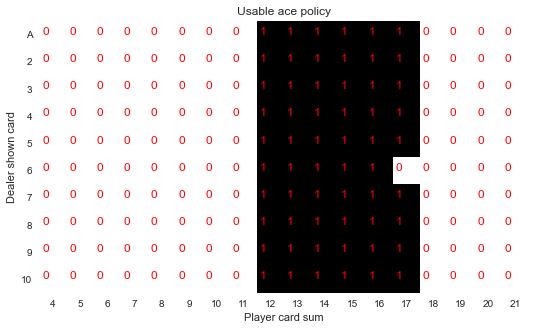

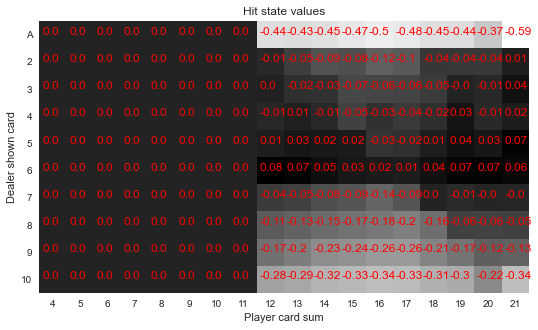

In [17]:
detailed_quality_plot(game.player.state_action_value[1, 0], "Stick state values")
detailed_quality_plot(np.argmax(game.player.state_action_value[1], 0), "Usable ace policy")
detailed_quality_plot(game.player.state_action_value[1, 1], "Hit state values")

# Off-policy MC prediction (policy evaluation) for estimation $Q\approx q_\pi$

In [67]:
game = Table()

counts = np.zeros_like(game.player.state_action_value, dtype=int)

eps = 0.5
gamma = 1
num_games = int(1e7)
for i in range(1, num_games+1):
    reward, states, actions = game.blackjack(eps)
    
    expected, weight = 0, 1
    for step in reversed(range(len(actions))):
        idx = Player.state_action_to_idx(states[step], actions[step])
        
        if step == len(actions)-1:
            expected = gamma *expected +reward
        else: expected = gamma *expected
            
        counts[idx] += weight
        if counts[idx] != 0:
            q_sa = game.player.state_action_value[idx]
            game.player.state_action_value[idx] += (weight/counts[idx]) * (expected -q_sa)
        
        action = game.player.policy(states[step], 0)
        if action == actions[step]: # Greedy
            prob_pi = 1
            prob_b = 1-eps+(eps/len(game.player.action_space))
        else:                       # Exploratory
            prob_pi = 0
            prob_b = eps/len(game.player.action_space)
            
        weight *= prob_pi / prob_b
        
    if i % (num_games//10) == 0:
        print(f"State-action value optimization is {i//(num_games//100)}% done.")

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


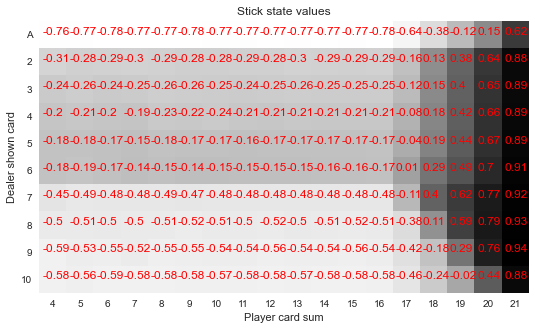

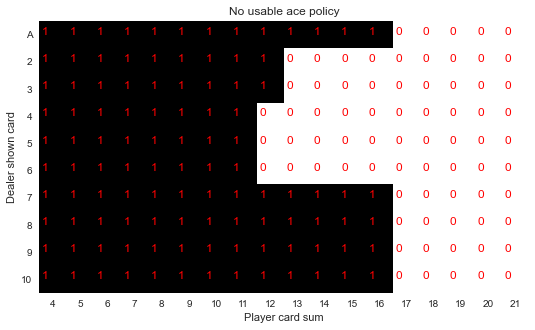

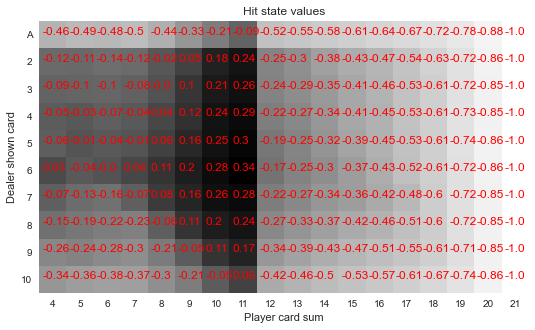

In [68]:
detailed_quality_plot(game.player.state_action_value[0, 0], "Stick state values")
detailed_quality_plot(np.argmax(game.player.state_action_value[0], 0), "No usable ace policy")
detailed_quality_plot(game.player.state_action_value[0, 1], "Hit state values")

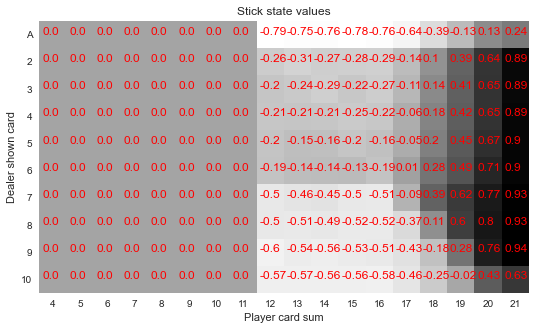

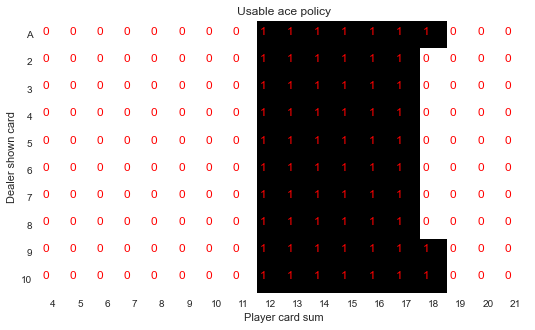

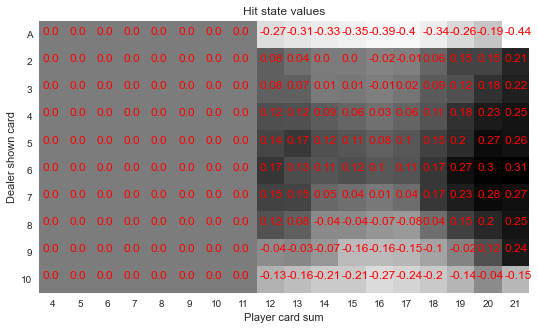

In [69]:
detailed_quality_plot(game.player.state_action_value[1, 0], "Stick state values")
detailed_quality_plot(np.argmax(game.player.state_action_value[1], 0), "Usable ace policy")
detailed_quality_plot(game.player.state_action_value[1, 1], "Hit state values")

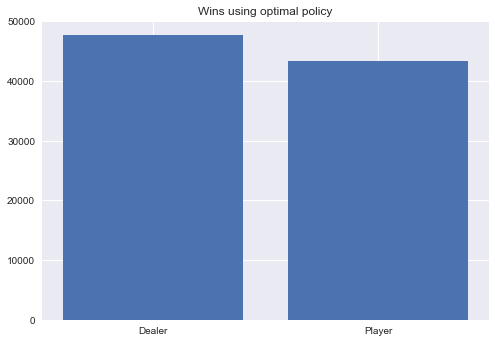

In [70]:
score = {"Dealer": 0, "Player": 0}

for _ in range(int(1e5)):
    # Following the policy greedily
    reward, _, _ = game.blackjack(eps=0)
    if reward < 0 : score["Dealer"] += 1
    elif reward > 0 : score["Player"] += 1
    
plt.bar(["Dealer", "Player"], score.values())
plt.title("Wins using optimal policy"); plt.show()

# Off-policy MC control, for estimating $\pi\approx\pi_*$

In [13]:
game = Table()

counts = np.zeros_like(game.player.state_action_value, dtype=int)

eps = 0.5
gamma = 1
num_games = int(1e7)
for i in range(1, num_games+1):
    reward, states, actions = game.blackjack(eps)
    
    expected, weight = 0, 1
    for step in reversed(range(len(actions))):
        idx = Player.state_action_to_idx(states[step], actions[step])
        
        if step == len(actions)-1:
            expected = gamma *expected +reward
        else: expected = gamma *expected
            
        counts[idx] += weight
        if counts[idx] != 0:
            q_sa = game.player.state_action_value[idx]
            game.player.state_action_value[idx] += (weight/counts[idx]) * (expected -q_sa)
        
        action = game.player.policy(states[step], 0)
        if action != actions[step]: break
            
        weight *= 1 / (1-eps+(eps/len(game.player.action_space)))
        
    if i % (num_games//10) == 0:
        print(f"State-action value optimization is {i//(num_games//100)}% done.")

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


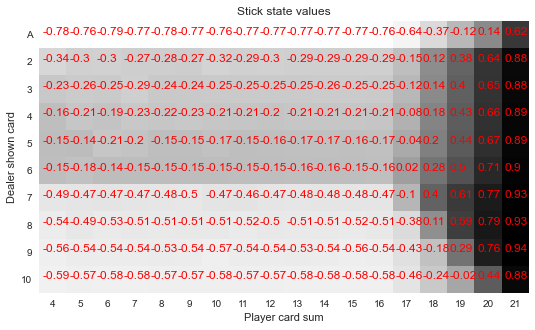

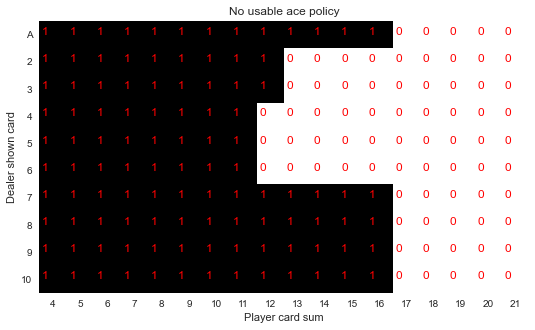

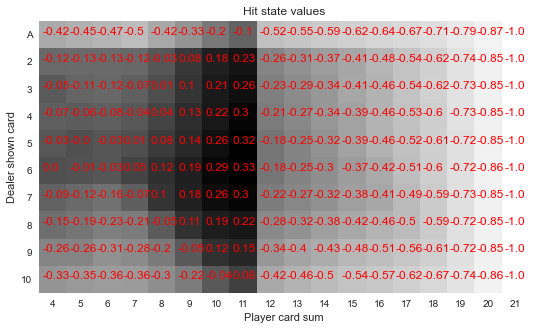

In [15]:
detailed_quality_plot(game.player.state_action_value[0, 0], "Stick state values")
detailed_quality_plot(np.argmax(game.player.state_action_value[0], 0), "No usable ace policy")
detailed_quality_plot(game.player.state_action_value[0, 1], "Hit state values")

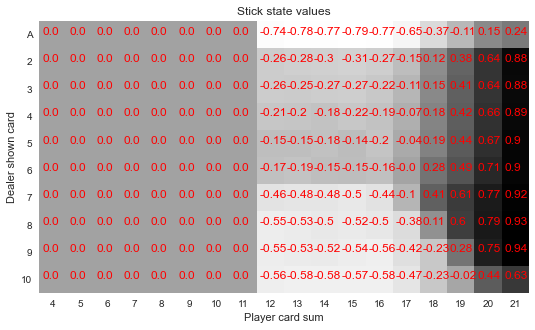

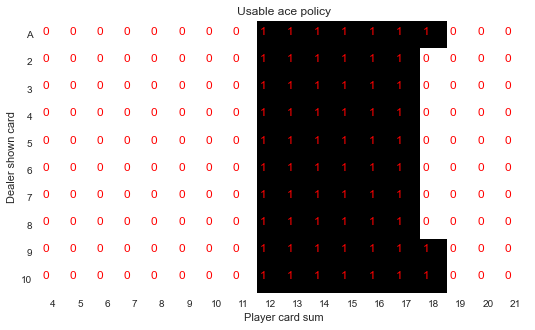

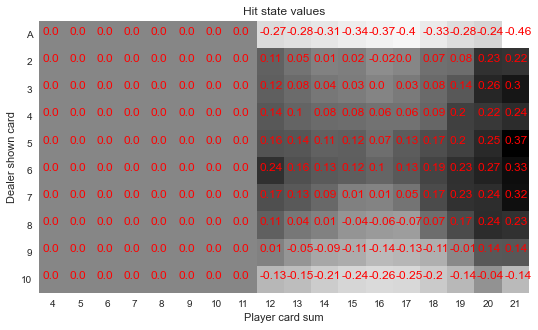

In [10]:
detailed_quality_plot(game.player.state_action_value[1, 0], "Stick state values")
detailed_quality_plot(np.argmax(game.player.state_action_value[1], 0), "Usable ace policy")
detailed_quality_plot(game.player.state_action_value[1, 1], "Hit state values")

# Blackjack game following optimized policy (greedy)

In [25]:
outcome = {-1: "Lost", 0: "Draw", 1:"Won"}

reward, states, actions = game.blackjack(0)
print("Game", outcome[reward])
print("States:", *states)
print("Actions:", *actions)

Game Won
States: (True, 3, 19)
Actions: 0


# It's alive!!! :)

Now let's see if there is an improvement

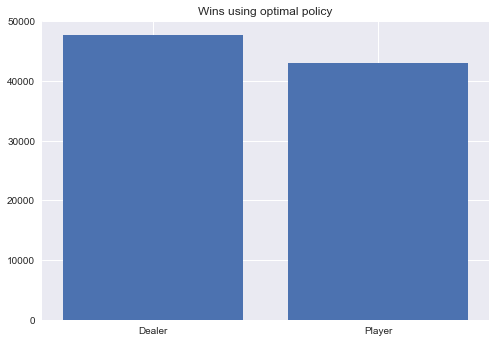

In [42]:
score = {"Dealer": 0, "Player": 0}

for _ in range(int(1e5)):
    # Following the policy greedily
    reward, _, _ = game.blackjack(eps=0)
    if reward < 0 : score["Dealer"] += 1
    elif reward > 0 : score["Player"] += 1
    
plt.bar(["Dealer", "Player"], score.values())
plt.title("Wins using optimal policy"); plt.show()

# Conclusion: NEVER EVER PLAY BLACKJACK :')

Even with the **perfect execution** of the players optimized policy: **dealer is still favoured and ~10% of games are draws**